In [1]:
# - Rockpool
from rockpool import TSEvent, TSContinuous
from rockpool.nn.modules import LIFJax, LinearJax, TimedModuleWrapper
from rockpool.nn.combinators import Sequential

from jax.config import config
config.update("jax_debug_nans", True)

from rockpool.devices.dynapse.utils.figure import Figure

from rockpool.devices.dynapse.dynapsim import (
    DynapSim,
)

from rockpool.devices.dynapse.fpga_jax import (
    DynapSEFPGA,
)

# - Numpy
import numpy as np

# - Plotting imports and config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

Could not import package: No module named 'iaf_nest'


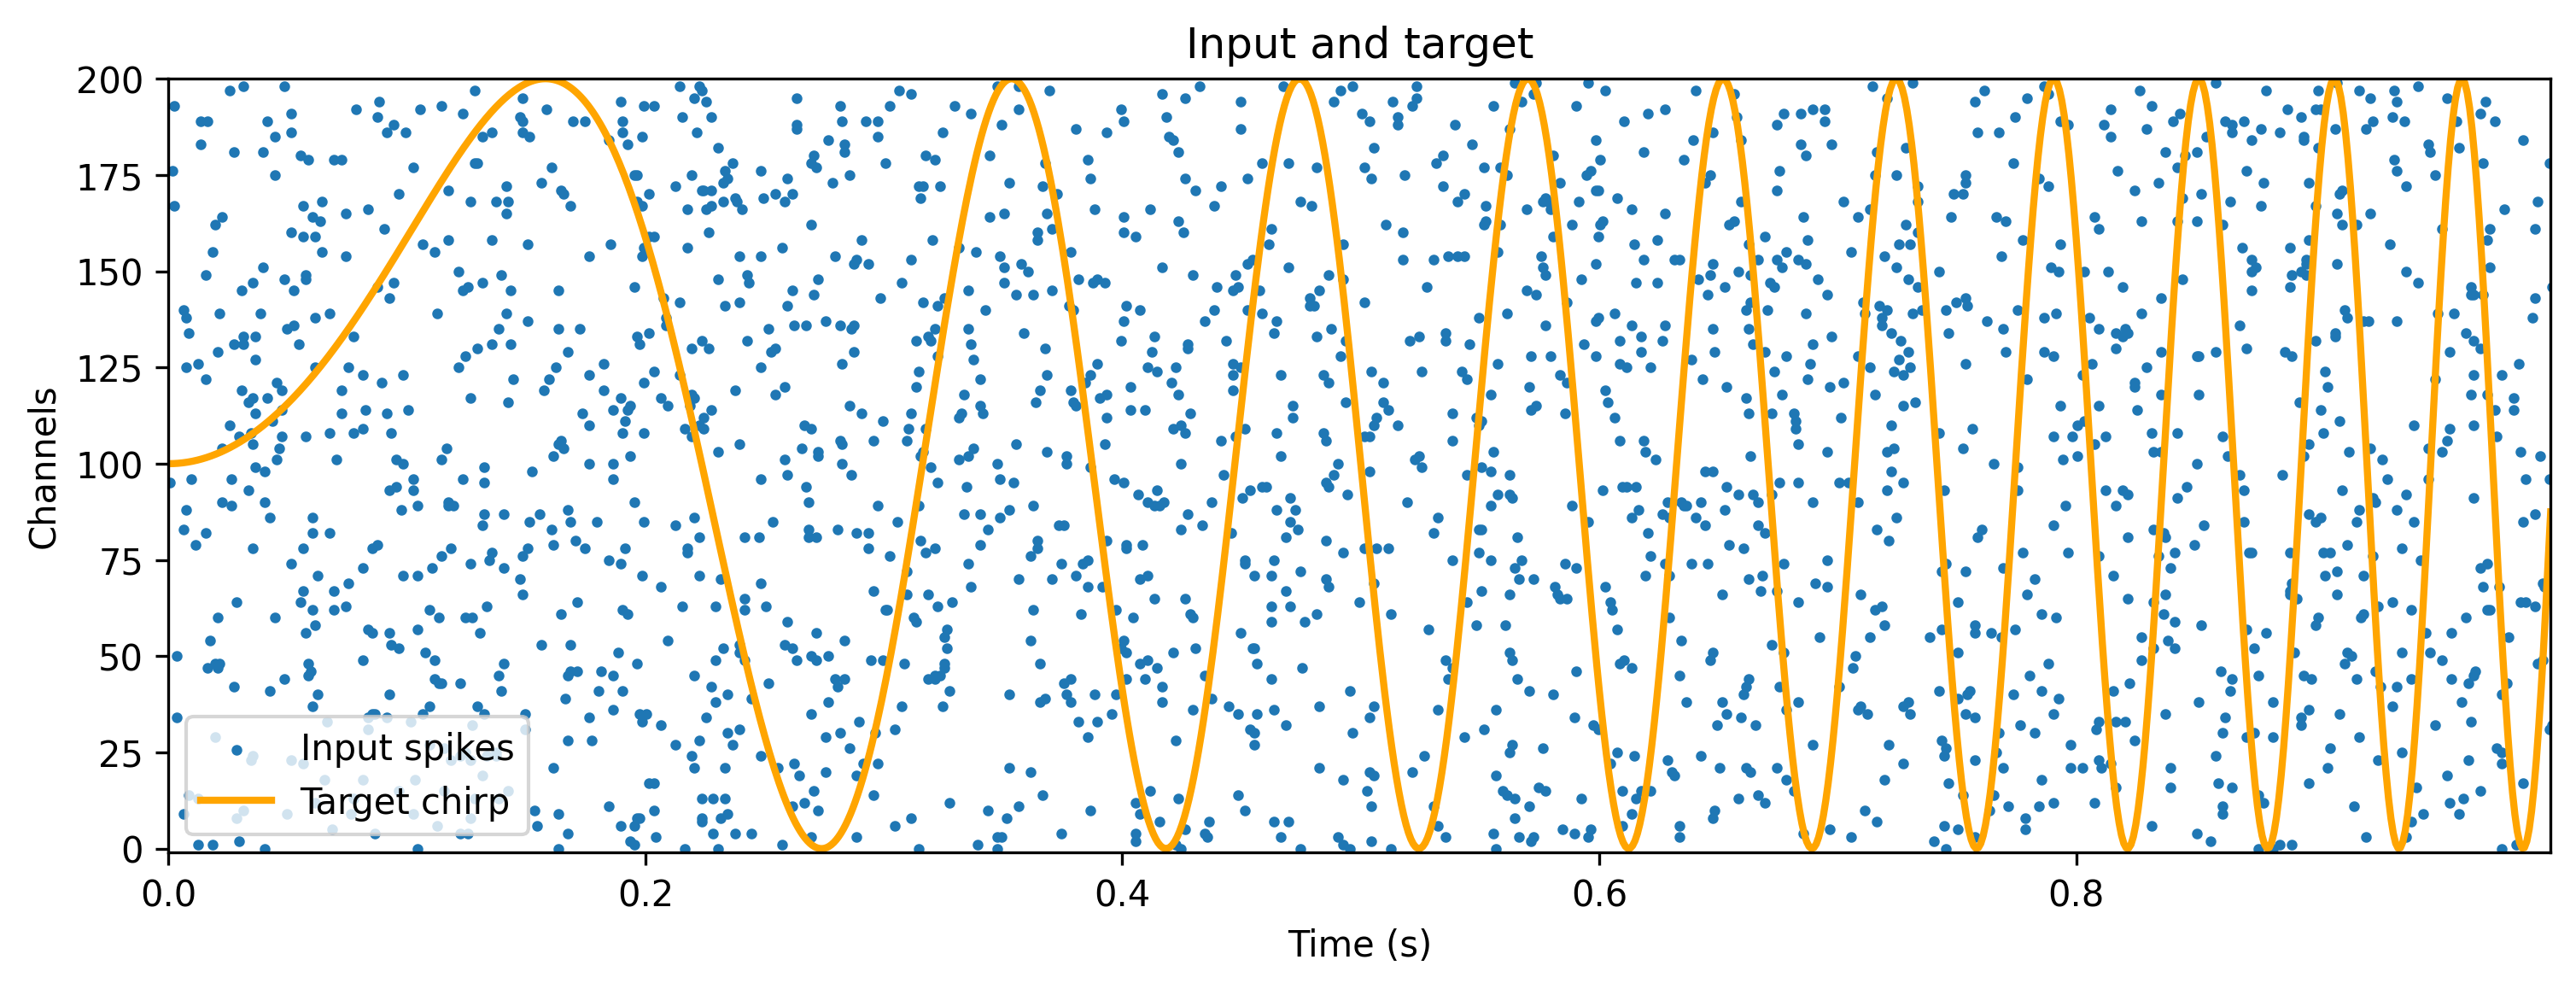

In [2]:
# - Define input and target
Nin = 200
dt = 1e-3
chirp_freq_factor = 10
dur_input = 1000e-3

# - Generate a time base
T = int(np.round(dur_input / dt))
timebase = np.linspace(0, (T-1) * dt, T)

# - Generate a chirp signal as a target
chirp = np.atleast_2d(np.sin(timebase * 2 * np.pi * (timebase * chirp_freq_factor))).T
target_ts = TSContinuous(timebase, chirp, periodic = True, name = 'Target chirp')

# - Generate a Poisson frozen random spike train
spiking_prob = .01
input_sp_raster = np.random.rand(T, Nin) < spiking_prob
input_sp_ts = TSEvent.from_raster(input_sp_raster, name = 'Input spikes', periodic = True, dt = dt)

# - Plot the input and target signals
plt.figure()
input_sp_ts.plot(s = 4)
(target_ts * Nin/2 + Nin/2).plot(color="orange", lw=2)
plt.legend()
plt.title('Input and target');

In [3]:
# Get random parameters for initialisation
N = 50
Nout = 1
modFFwd = TimedModuleWrapper(Sequential(
    DynapSEFPGA((Nin, N*4)),
    DynapSim((N*4,N),dt=dt),
    LinearJax((N, Nout), weight = 2 * np.random.rand(N, Nout) - 1, spiking_input=True),
), dt = dt)

modFFwd

TimedModuleWrapper  with shape (200, 1) {
    JaxSequential '_module' with shape (200, 1) {
        DynapSEFPGA '0_DynapSEFPGA' with shape (200, 200)
        DynapSim '1_DynapSim' with shape (200, 50)
        LinearJax '2_LinearJax' with shape (50, 1)
    }
} with JaxSequential '_module' as module

In [4]:
fpga = modFFwd._module.__getattribute__("0_DynapSEFPGA")
se1 = modFFwd._module.__getattribute__("1_DynapSim")

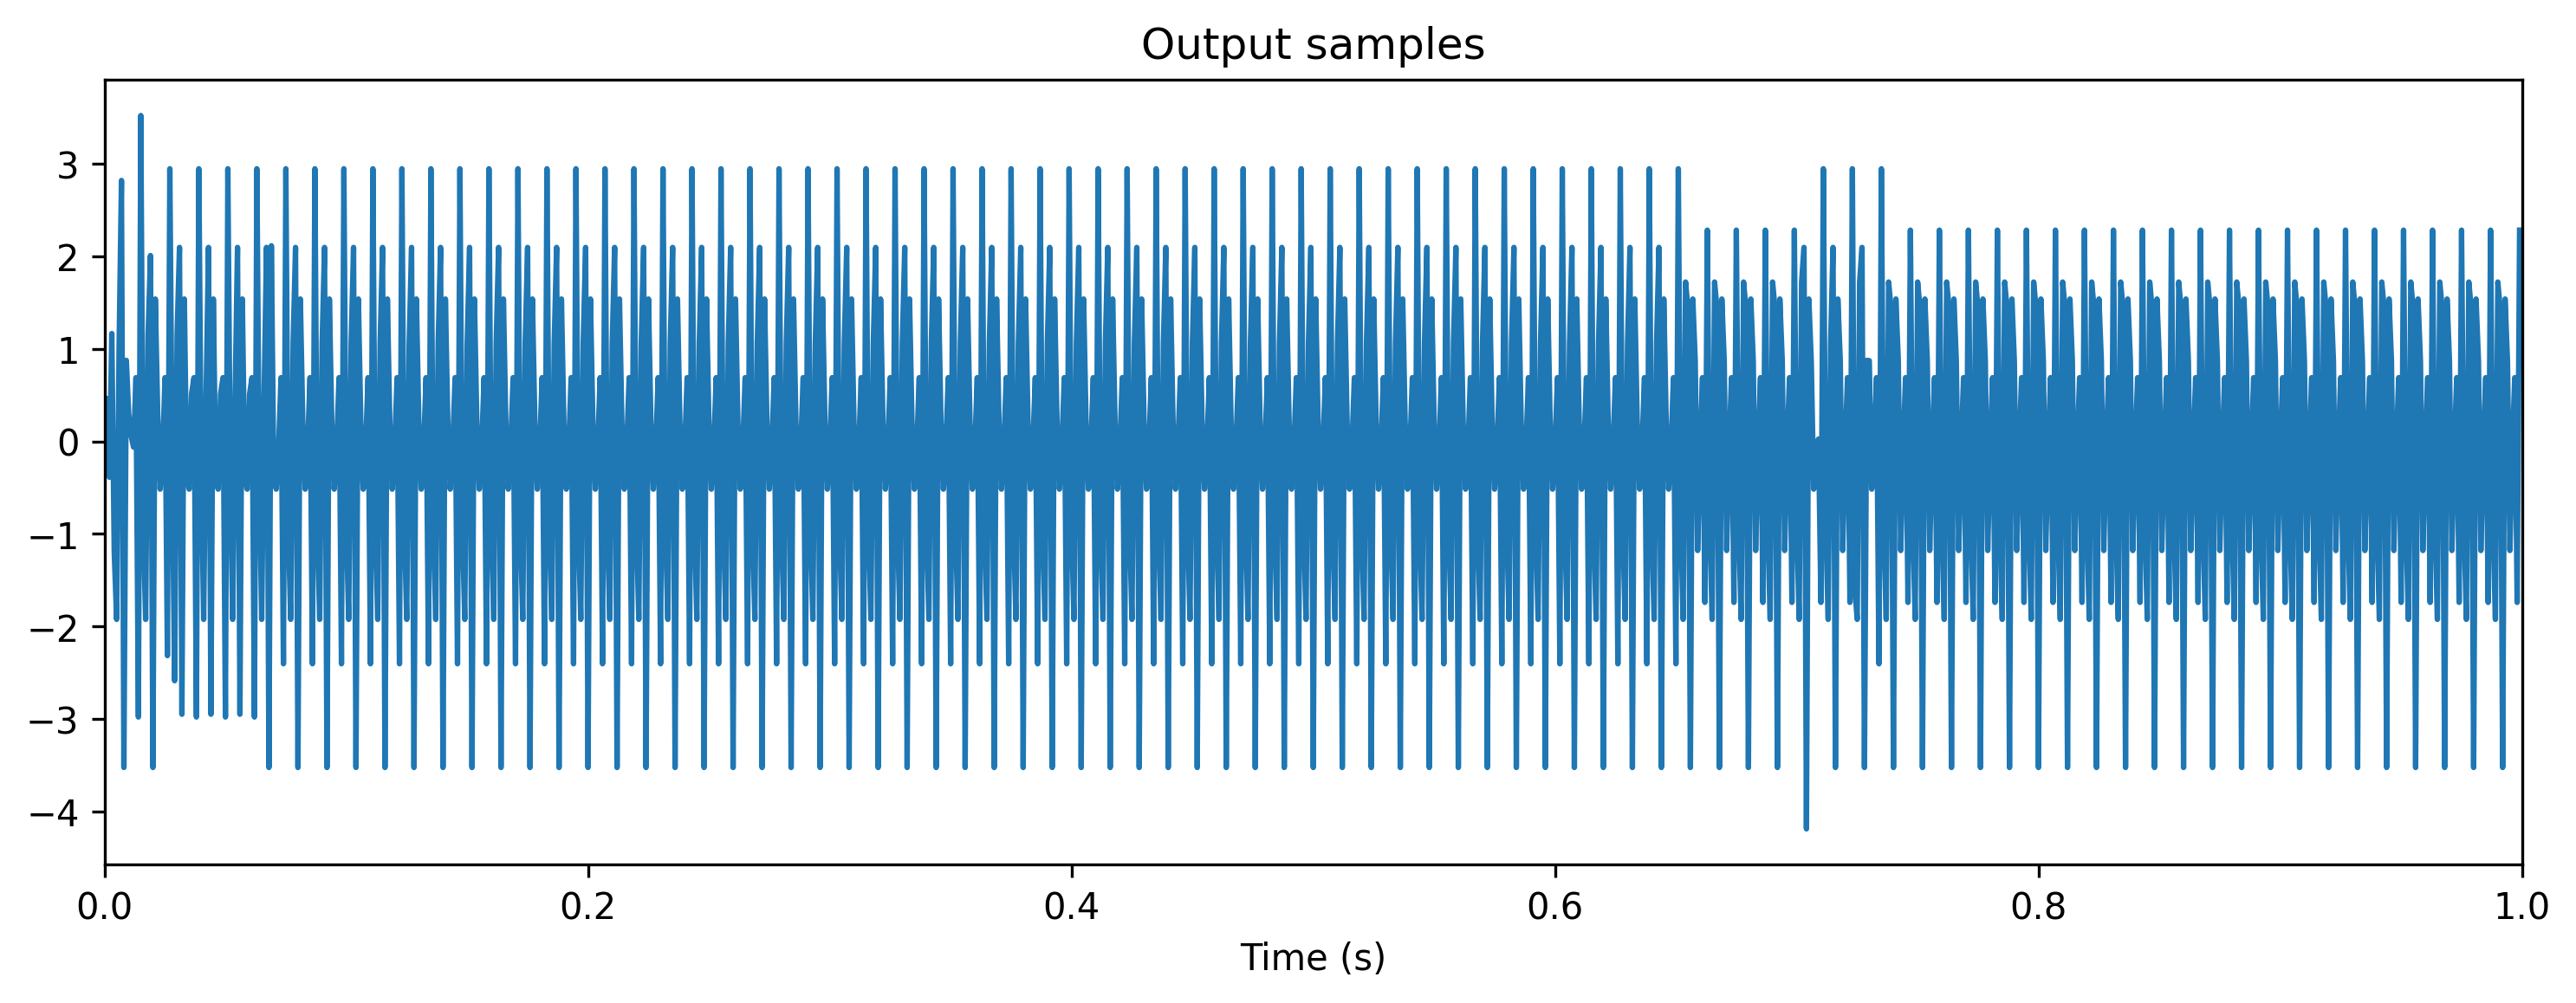

In [5]:
# - Randomise the network state
modFFwd.reset_state()

# - Evolve with the frozen noise spiking input
tsOutput, new_state, record_dict = modFFwd(input_sp_ts, record = False)

# - Plot the analog output
plt.figure()
tsOutput.plot();

In [6]:
# # - Make a function that converts ``record_dict``
# def plot_record_dict(rd):
#     Vmem_ts = TSContinuous.from_clocked(rd['1_DynapSim']['Vmem'], dt = dt, name = '$V_{mem}$')

#     # - Plot the internal activity of selected neurons
#     plt.figure()
#     Vmem_ts.plot(stagger = 1.1, skip = 5)

# plot_record_dict(record_dict)

In [7]:
# modSE = modFFwd._module.__getattribute__("1_DynapSim")
# output_spikes = record_dict['1_DynapSim']['spikes']
# Figure.plot_spikes(output_spikes, name="Output Spikes");

In [8]:
# - Import the convenience functions
from rockpool.training.jax_loss import bounds_cost, make_bounds

p = {
    '0_DynapSEFPGA' : {
        'w_in' : modFFwd.module.parameters()['0_DynapSEFPGA']['w_in'],
    },
    '1_DynapSim' : {
        'w_rec' : modFFwd.module.parameters()['1_DynapSim']['w_rec'],
    },
    '2_LinearJax' : modFFwd.module.parameters()['2_LinearJax']}

# - Generate a set of pre-configured bounds
lower_bounds, upper_bounds = make_bounds(p)
print('lower_bounds: ', lower_bounds,
      'upper_bounds: ', upper_bounds)

lower_bounds:  {'0_DynapSEFPGA': {'w_in': -inf}, '1_DynapSim': {'w_rec': -inf}, '2_LinearJax': {'bias': -inf, 'weight': -inf}} upper_bounds:  {'0_DynapSEFPGA': {'w_in': inf}, '1_DynapSim': {'w_rec': inf}, '2_LinearJax': {'bias': inf, 'weight': inf}}


In [9]:
lower_bounds['0_DynapSEFPGA']['w_in'] = 0
upper_bounds['0_DynapSEFPGA']['w_in'] = 1e-5
lower_bounds['1_DynapSim']['w_rec'] = 0
upper_bounds['1_DynapSim']['w_rec'] = 1e-5

In [10]:
print('lower_bounds: ', lower_bounds,
      'upper_bounds: ', upper_bounds)

lower_bounds:  {'0_DynapSEFPGA': {'w_in': 0}, '1_DynapSim': {'w_rec': 0}, '2_LinearJax': {'bias': -inf, 'weight': -inf}} upper_bounds:  {'0_DynapSEFPGA': {'w_in': 1e-05}, '1_DynapSim': {'w_rec': 1e-05}, '2_LinearJax': {'bias': inf, 'weight': inf}}


In [11]:
# - Define a constrained MSE loss function
import rockpool.training.jax_loss as l

def loss_mse(parameters, net, inputs, target):
    # - Handle the network state — randomise or reset
    # print("\t Reset State:")
    net = net.reset_state()

    # print("\t Set Attributes:")
    # - Assign the provided parameters to the network
    net = net.set_attributes(parameters)


    # print("\t Evolve:")
    # - Evolve the network to get the ouput
    output, _, _ = net(inputs)

    # print("\t Bounds:")
    # - Impose the bounds
    bounds = bounds_cost(parameters, lower_bounds, upper_bounds) * 1e3

    # print("\t Done!")
    # - Compute a loss value w.r.t. the target output
    return l.mse(output, target) + bounds

## JIT

In [12]:
# - Useful imports
from copy import deepcopy
from itertools import count
from tqdm.autonotebook import tqdm

# -- Import an optimiser to use and initalise it
import jax
from jax.example_libraries.optimizers import adam

# - Get the optimiser functions
init_fun, update_fun, get_params = adam(1e-12)

# - Initialise the optimiser with the initial parameters
params0 = deepcopy(p)
opt_state = init_fun(params0)

# - Get a compiled value-and-gradient function
loss_vgf = jax.jit(jax.value_and_grad(loss_mse)) ## JIT JIT JIT JIT
# loss_vgf = jax.value_and_grad(loss_mse) ## NON-JIT NON-JIT NON-JIT NON-JIT

# - Compile the optimiser update function
update_fun = jax.jit(update_fun) ## JIT JIT JIT JIT

# print("Init :", DynapSim.count_init)

# - Record the loss values over training iterations
loss_t = []
grad_t = []

num_epochs = 100

# - Loop over iterations
i_trial = count()
pbar = tqdm(range(num_epochs))
for _ in pbar:
    
    # - Get parameters for this iteration
    params = get_params(opt_state)
    # print(f"iteration {i} `get_params` :", DynapSim.count_run)
    # print(params['1_DynapSim'].keys())

    # - Get the loss value and gradients for this iteration
    loss_val, grads = loss_vgf(params, modFFwd.module, input_sp_raster, chirp)
    # print(f"iteration {i} `loss` :", DynapSim.count_run)

    # - Update the optimiser
    opt_state = update_fun(next(i_trial), grads, opt_state)
    # print(f"iteration {i} `update` :", DynapSim.count_run)

    # - Keep track of the loss
    loss_t.append(loss_val)
    pbar.set_postfix({'loss': loss_val})

    # print(f"iteration {i}:", DynapSim.count_run)

# print("\n\nFinal_init :", DynapSim.count_init)
# print("Final_run :", DynapSim.count_run)
# 2.55, 39.5, < 15
# 2.89, 34.7 >15


  0%|          | 0/100 [00:00<?, ?it/s]WARNING:root:A new simconfig object is created for FPGA input module!


Invalid value encountered in the output of a jit/pmap-ed function. Calling the de-optimized version.


  0%|          | 0/100 [00:31<?, ?it/s]


FloatingPointError: invalid value (nan) encountered in scan

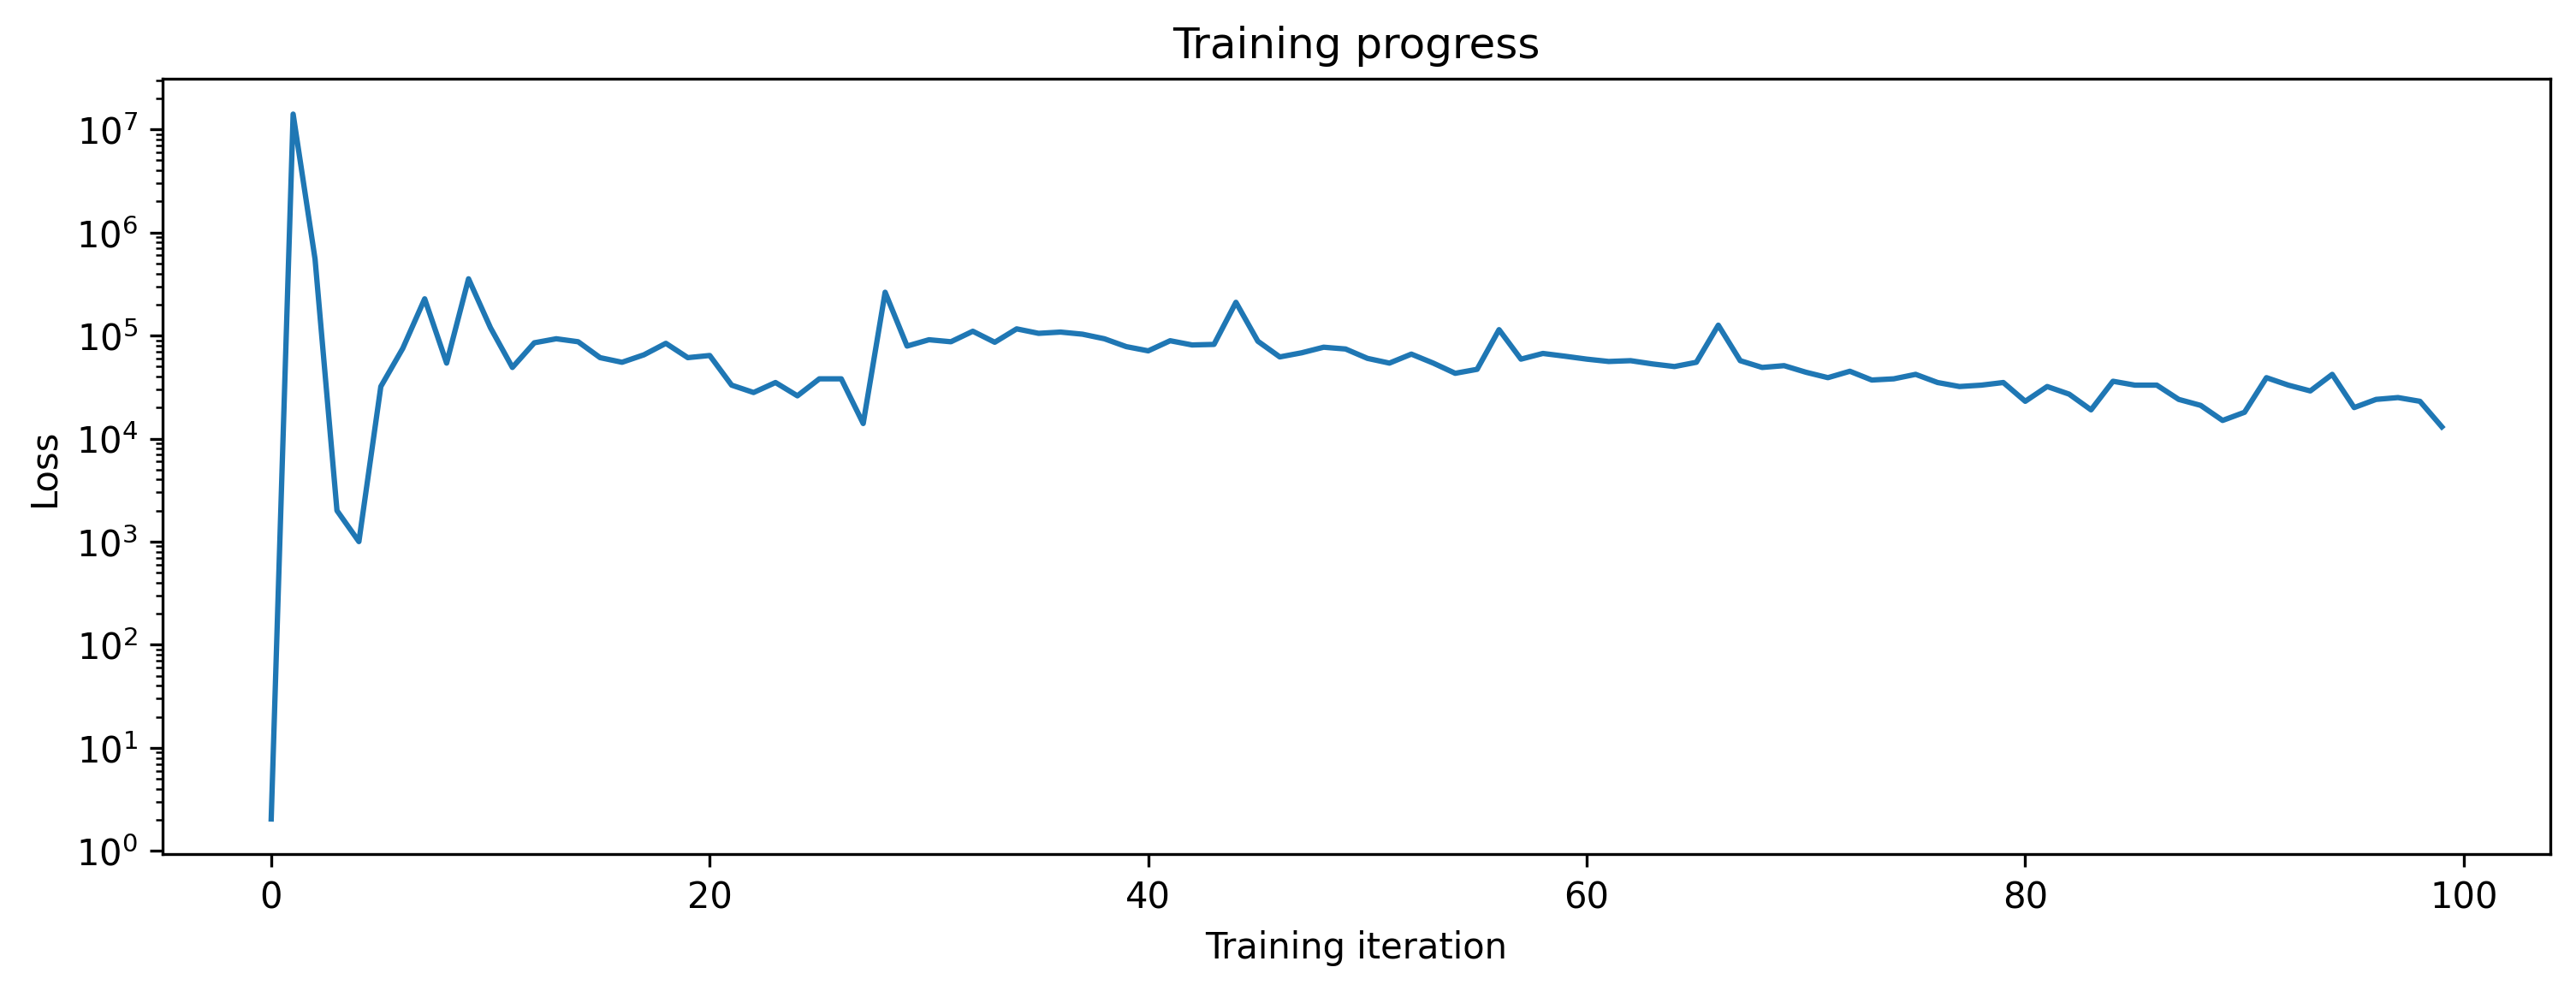

In [ ]:
# - Plot the loss 
plt.figure()
plt.plot(loss_t)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Training iteration');
plt.title('Training progress');

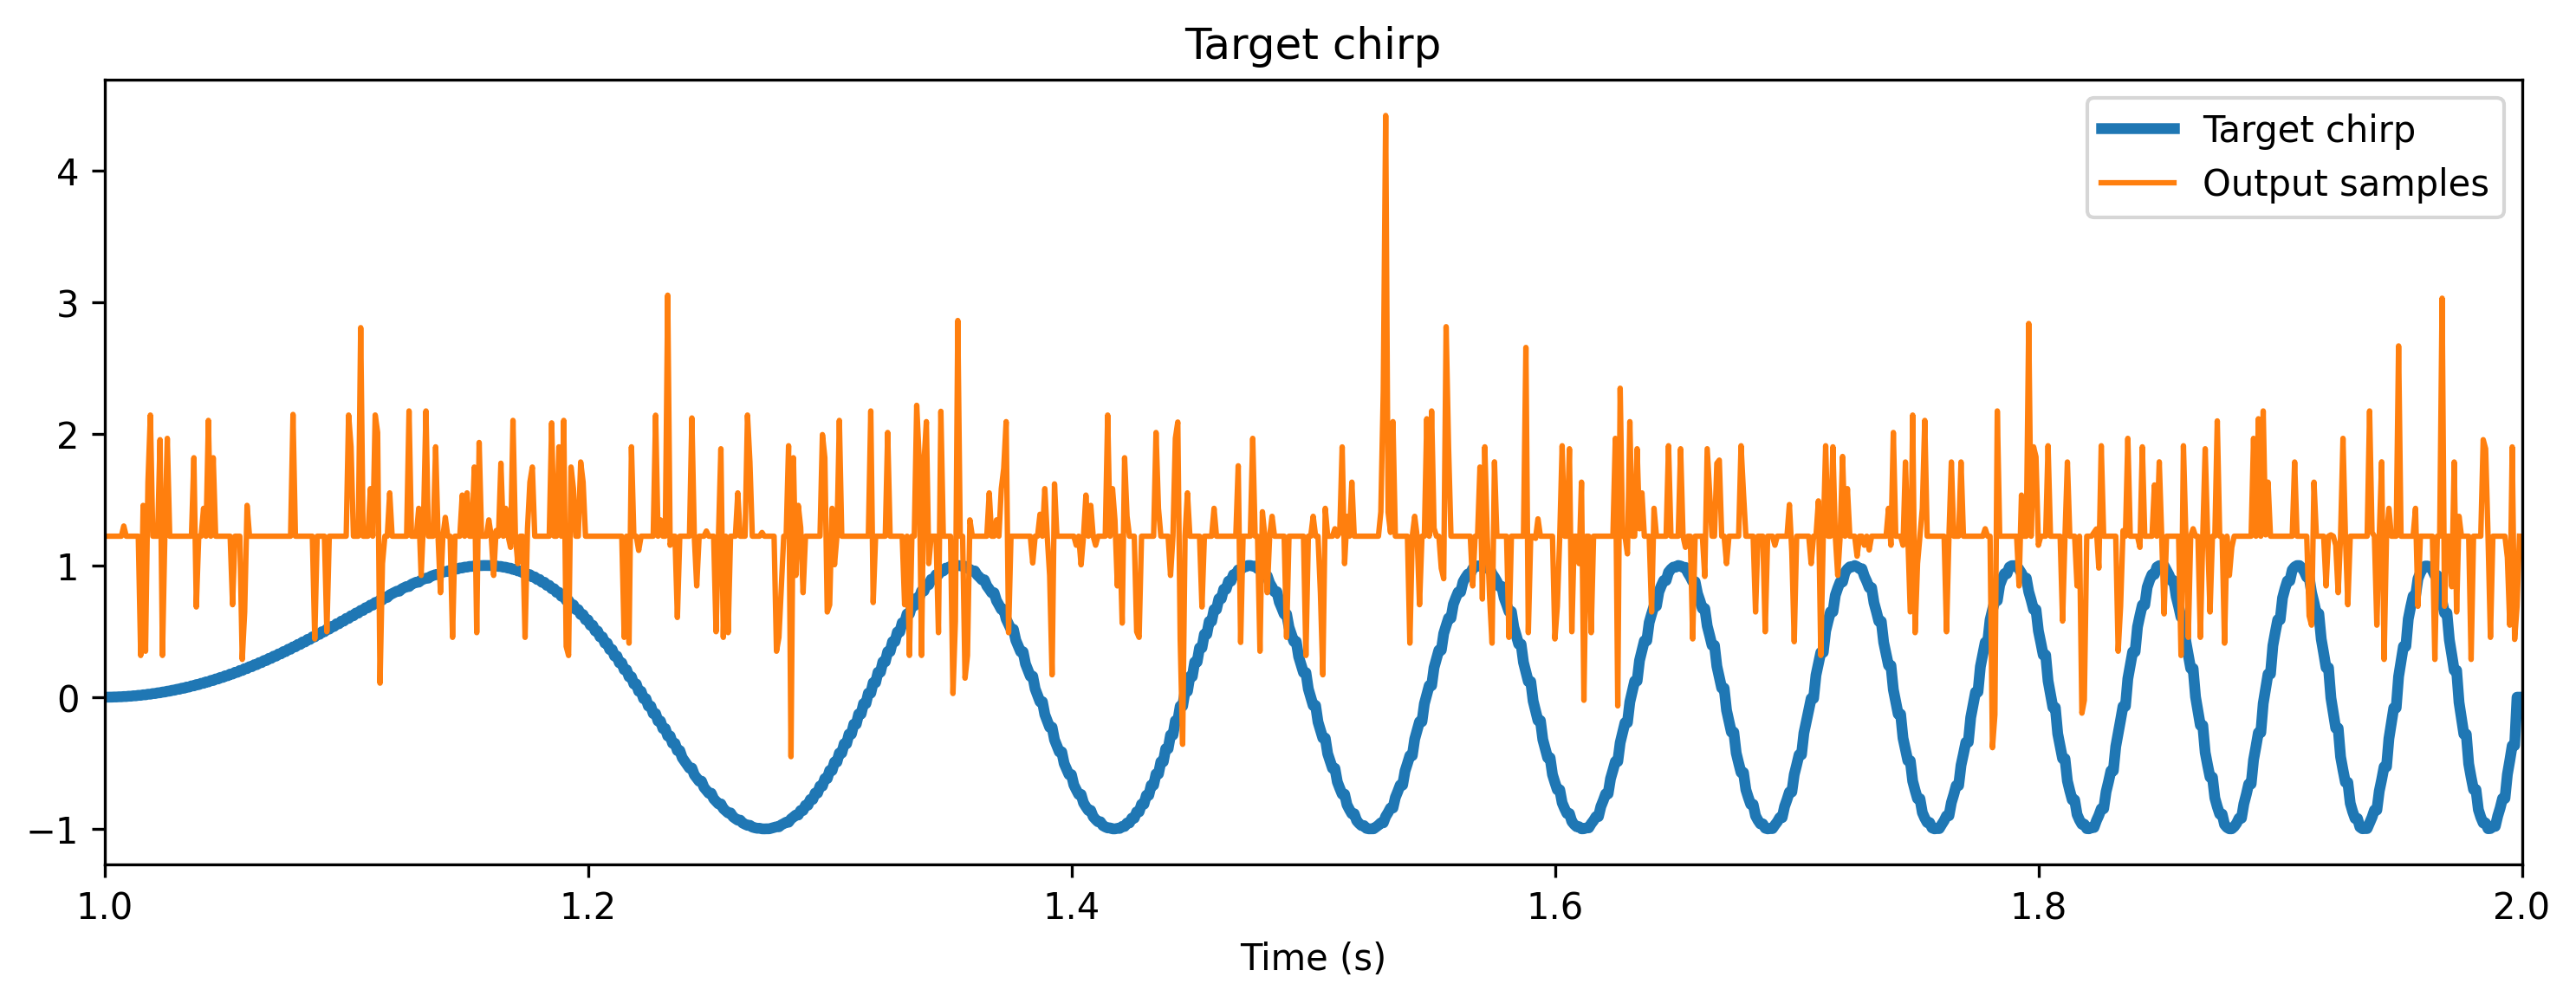

In [ ]:
# - Simulate with trained parameters
modFFwd._module = modFFwd._module.set_attributes(get_params(opt_state))
modFFwd._module = modFFwd._module.reset_state()
output_ts, _, record_dict = modFFwd(input_sp_ts)

# - Compare the output to the target
plt.figure()
target_ts.plot(output_ts.times, lw=3)
output_ts.plot()
plt.legend()

# # - Plot the internal state of selected neurons
# plot_record_dict(record_dict)

In [ ]:
fpga = modFFwd._module.__getattribute__("0_DynapSEFPGA")
se1 = modFFwd._module.__getattribute__("1_DynapSim")
se1.w_rec

array([[[0.e+00, 0.e+00, 0.e+00, 2.e-06],
        [0.e+00, 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, 0.e+00],
        ...,
        [0.e+00, 0.e+00, 0.e+00, 2.e-06],
        [0.e+00, 0.e+00, 0.e+00, 1.e-06],
        [0.e+00, 0.e+00, 0.e+00, 0.e+00]],

       [[0.e+00, 0.e+00, 0.e+00, 1.e-06],
        [0.e+00, 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, 1.e-06],
        ...,
        [0.e+00, 1.e-06, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, 0.e+00]],

       [[0.e+00, 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 1.e-06, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, 0.e+00],
        ...,
        [0.e+00, 0.e+00, 0.e+00, 1.e-06],
        [0.e+00, 0.e+00, 1.e-06, 1.e-06],
        [0.e+00, 0.e+00, 0.e+00, 0.e+00]],

       ...,

       [[0.e+00, 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, 0.e+00],
        ...,
        [0.e+00, 0.e+00, 0.e+00, 0.e+00],
     

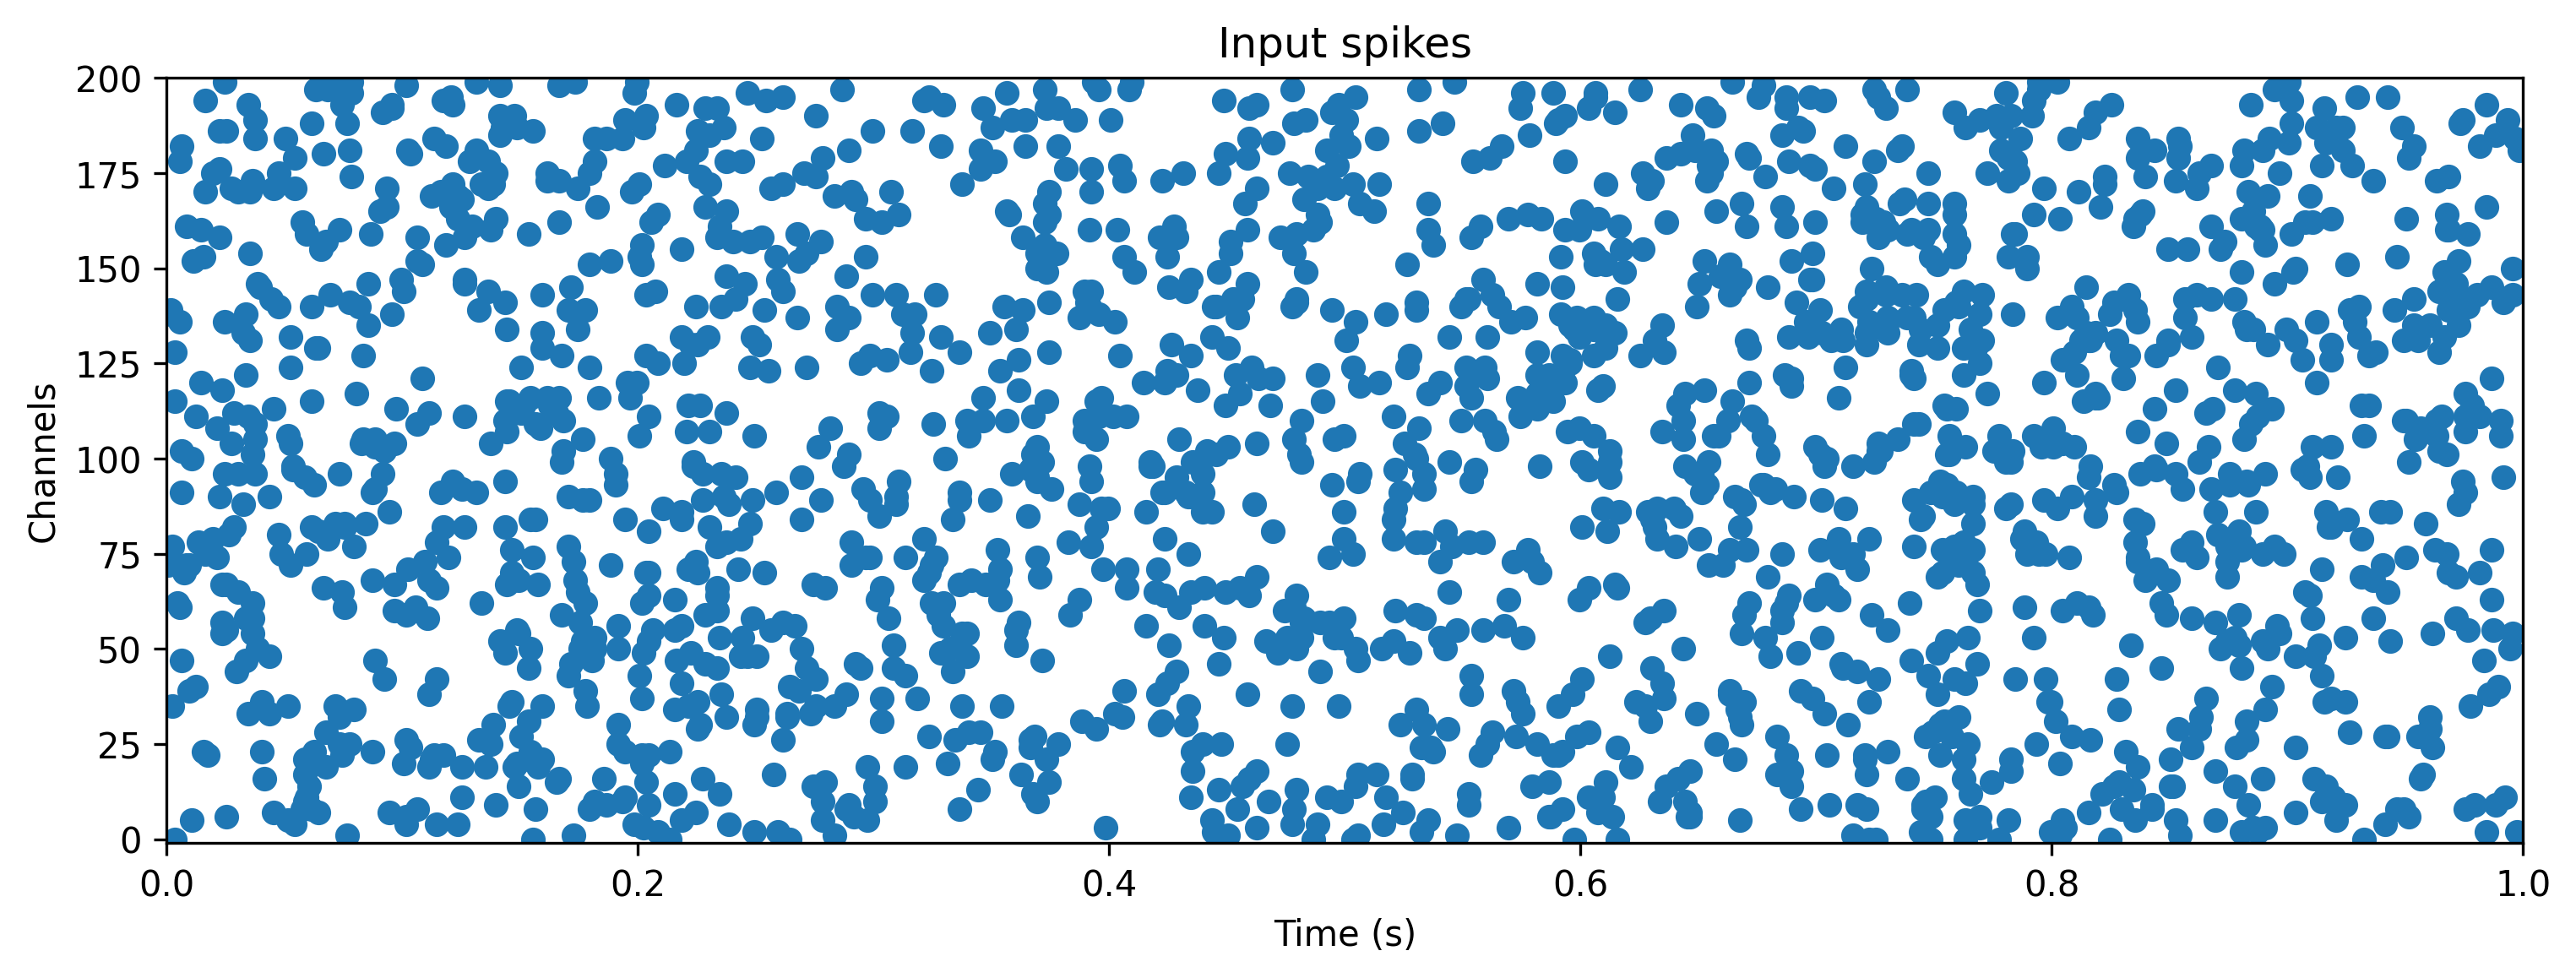

In [ ]:
input_sp_ts.plot()